# Capstone Project - The Battle of the Neighborhoods
### Final Project for: Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal destination for my cousin's senior trip next year. This report will be comparing 2 locations specifically: **Manhattan** and **Toronto**. Both of the datasets are from module 3.

Since we are trying to find a location that would be appealing to a young high school graduate, it is important to take consideration of **venues that commonly interests teenagers**. We are taking a look at the **density** of those venues and the **variaty** of the types of venues in the area.

We will use our data science powers to decide on a destination first. Then 5 neighborhoods will be selected from the area for visit.

**Code Credit:** Portions of code used for this project is taken from Coursera's course: "Applied Data Science Capstone". 

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* determine if the certain types of venue that exist in the neighborhood would be intersting to a teenager
* the variaties of venues in a neighborhood

We decided to use geocoders to convert an address into latitude and longitude values. We will also be using FourSqaure for the venues information in seleted neighborhoods.

Following data sources will be needed to extract/generate the required information:
* data frames of venues based on neighborhoods in both cities
* the frequency of each type of venues 
* the number of unique venues from each neighborhood


---

Import all the libraries needed.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Dataframe for Manhattan (from labs)

In [3]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [9]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Use geolocator to get latitide and longitude.

In [10]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
m_latitude = location.latitude
m_longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(m_latitude, m_longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


Use the Foursquare API and save the credentials.

In [11]:
CLIENT_ID = 'SKW42UIX3FIRN5TTNDT1TSIPJ5W3BI4PMVIBJPGEPPQY30Z3' # your Foursquare ID
CLIENT_SECRET = '3XIVDZ1ADDR3XZHJ054BJESUKBPRFK1DO1AC1QUZYAZTGKDQ' # your Foursquare Secret
VERSION = '20210802' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SKW42UIX3FIRN5TTNDT1TSIPJ5W3BI4PMVIBJPGEPPQY30Z3
CLIENT_SECRET:3XIVDZ1ADDR3XZHJ054BJESUKBPRFK1DO1AC1QUZYAZTGKDQ


Use Foursquare to get all the near by venues to a neighborhood.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [14]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3259, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


### Data Frame for Toronto (froom week 3)

Use the wikipedia data and webscrape for the dataframe.

In [15]:
# set-ups
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html5lib')

In [16]:
# from week3 forums 
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [17]:
print(df.shape)
df.head()

(103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Use Geospatial_Coordinates.csv for the coordinates for each postal code.

These are the credentials and pandasDataFrame generated by Jupyter Notebook.

In [18]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-6e31a132-5132-41fa-a934-5dd37ba36815',
    'IBM_API_KEY_ID': 'm-ASEAWhji-UZj_UnKu_0p98Fby8qmq5enW8npVSDKmH',
    'ENDPOINT': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'capstoneproject-donotdelete-pr-3fz4jmijxteuh5',
    'FILE': 'Geospatial_Coordinates.csv'
}


In [19]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_97e876c395bd4ab1b7c162ef6638ea35 = 'https://s3.us.cloud-object-storage.appdomain.cloud'
else:
    endpoint_97e876c395bd4ab1b7c162ef6638ea35 = 'https://s3.private.us.cloud-object-storage.appdomain.cloud'

client_97e876c395bd4ab1b7c162ef6638ea35 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='m-ASEAWhji-UZj_UnKu_0p98Fby8qmq5enW8npVSDKmH',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_97e876c395bd4ab1b7c162ef6638ea35)

body = client_97e876c395bd4ab1b7c162ef6638ea35.get_object(Bucket='capstoneproject-donotdelete-pr-3fz4jmijxteuh5',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [20]:
df_data.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
df = df.join(df_data.set_index('PostalCode'), on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [21]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto-explorer")
location = geolocator.geocode(address)
t_latitude = location.latitude
t_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(t_latitude, t_longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Separate out all the borough that includes "Toronto".

In [22]:
df_toronto_borough = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_borough.shape
df_toronto_borough.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


Use Foursquare to get all the near by venues to a neighborhood.

In [23]:
def getNearbyVenues(boroughs, neighborhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for borough, neighborhood, lat, lng in zip(boroughs, neighborhoods, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            neighborhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
borough_neighborhood_venues = getNearbyVenues(boroughs=df_toronto_borough['Borough'],
                                             neighborhoods=df_toronto_borough['Neighborhood'],
                                             latitudes=df_toronto_borough['Latitude'],
                                             longitudes=df_toronto_borough['Longitude'])

We don't need the information on Borough since there's no information on Borough for Manhattan.

In [25]:
borough_neighborhood_venues.drop(['Borough'], axis=1, inplace=True)

In [26]:
print(borough_neighborhood_venues.shape)
borough_neighborhood_venues.head()

(1594, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting neighborhoods of both cities that have more number and variaty in venues. We will be using all the data that has been generated by Foursquare and manipulate the data frames to fit our needs.

Firstly we display all types of venues from both cities and delete the rows that contains information of the type of venue that is not typically interesting to a teenager. This this to ensure that the number we calculate later is entirely consist of areas that the traveller would want to visit on a trip.

Secondly we find out the top 5 neighborhood/area in both cities and their corresponding information about the venues, include both the amount and the variaty of types.

Lastly we create data frame for the information we found in the second step and compare the two data frames using visual tools (**bar graph**). 

## Analysis <a name="analysis"></a>

First we take a look at all types of venues in both cities and determine which ones would be undesireble to visit on a trip for a teenage.

These are all types of venues in Toronto.

In [27]:
borough_neighborhood_venues['Venue Category'].unique()

array(['Bakery', 'Coffee Shop', 'Distribution Center', 'Restaurant',
       'Spa', 'Park', 'Gym / Fitness Center', 'Pub', 'Breakfast Spot',
       'Historic Site', 'Chocolate Shop', 'Farmers Market',
       'Performing Arts Venue', 'Dessert Shop', 'Mexican Restaurant',
       'French Restaurant', 'Theater', 'Yoga Studio', 'Shoe Store',
       'Event Space', 'Café', 'Asian Restaurant', 'Art Gallery',
       'Electronics Store', 'Bank', 'Beer Store', 'Health Food Store',
       'Antique Shop', 'Playground', 'Clothing Store', 'Comic Shop',
       'Pizza Place', 'Plaza', 'Burrito Place', 'Burger Joint',
       'Ramen Restaurant', 'Music Venue', 'Sandwich Place',
       'Movie Theater', 'Sporting Goods Shop', 'Steakhouse',
       'Sushi Restaurant', 'Shopping Mall', 'Japanese Restaurant',
       'New American Restaurant', 'Tanning Salon', 'Diner',
       'Fast Food Restaurant', 'Hotel', 'College Rec Center',
       'Thai Restaurant', 'Gastropub', 'Cosmetics Shop', 'Bookstore',
       'Moder

Numbers of unique venues in the city.

In [28]:
borough_neighborhood_venues['Venue Category'].nunique()

231

Dropping the rows with the types of venues that is undesired by a teenage visiter.

In [29]:
array1 = ['Distribution Center', 'Gym / Fitness Center', 'Pub', 'Yoga Studio', 'Electronics Store',
       'Bank', 'Beer Store', 'Health Food Store','Sporting Goods Shop', 'College Rec Center',
       'Gastropub', 'Furniture / Home Store', 'Lounge',
       'Department Store', 'Lingerie Store', 'Gym', 'Office', 'Kitchen Supply Store', 'Smoke Shop',
       'Hookah Bar', 'Camera Store', 'Cocktail Bar', 'Beer Bar','Tailor Shop', 'Salon / Barbershop',
       'Pharmacy', 'Wine Bar', 'Irish Pub', 'Neighborhood', 'Liquor Store', 
       'Basketball Stadium', 'Jazz Club', 'Bar','Baby Store', 'Nightclub',
       'Athletics & Sports', 'Speakeasy', 'Monument / Landmark',
       'Building', 'Brewery', 'Wine Shop', 'Convenience Store', 'Skating Rink',
       'IT Services', 'Roof Deck', 'Sports Bar', 'Dance Studio',
       'Train Station', 'Baseball Stadium', 'Scenic Lookout',
       "Men's Store", 'General Travel','Pet Store', 'Climbing Gym', 'Stadium', 'Intersection',
       'Coworking Space', 'Swim School', 'Bus Line', 'Rental Car Location', 'Gas Station', 'Tennis Court', 'College Gym',
       'College Arts Building', 'Hospital', 'Light Rail Station',
       'Airport', 'Airport Lounge', 'Airport Food Court', 'Airport Terminal', 'Airport Gate', 'Plane',
       'Airport Service', 'Optical Shop', 'Church',
       'Hostel', 'Butcher', 'Martial Arts School','Hobby Shop', 'Sake Bar', 'Skate Park',]
borough_neighborhood_venues.drop(borough_neighborhood_venues[borough_neighborhood_venues['Venue Category'].isin(array1)].index, inplace=True)


What are left in the data frame are the venues that might interst a teenage visitor

In [30]:
print(borough_neighborhood_venues['Venue Category'].nunique())
borough_neighborhood_venues['Venue Category'].unique()


150


array(['Bakery', 'Coffee Shop', 'Restaurant', 'Spa', 'Park',
       'Breakfast Spot', 'Historic Site', 'Chocolate Shop',
       'Farmers Market', 'Performing Arts Venue', 'Dessert Shop',
       'Mexican Restaurant', 'French Restaurant', 'Theater', 'Shoe Store',
       'Event Space', 'Café', 'Asian Restaurant', 'Art Gallery',
       'Antique Shop', 'Playground', 'Clothing Store', 'Comic Shop',
       'Pizza Place', 'Plaza', 'Burrito Place', 'Burger Joint',
       'Ramen Restaurant', 'Music Venue', 'Sandwich Place',
       'Movie Theater', 'Steakhouse', 'Sushi Restaurant', 'Shopping Mall',
       'Japanese Restaurant', 'New American Restaurant', 'Tanning Salon',
       'Diner', 'Fast Food Restaurant', 'Hotel', 'Thai Restaurant',
       'Cosmetics Shop', 'Bookstore', 'Modern European Restaurant',
       'Miscellaneous Shop', 'Seafood Restaurant',
       'Middle Eastern Restaurant', 'Tea Room', 'Lake',
       'Italian Restaurant', 'Bubble Tea Shop', 'Ethiopian Restaurant',
       'Toy / Ga

Now show the data frame after it's been modified.

In [31]:
print(borough_neighborhood_venues.shape)
borough_neighborhood_venues.head()

(1230, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
5,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park


We are repeating the same process with the Manhattan data frame.

In [32]:
print(manhattan_venues['Venue Category'].nunique())
manhattan_venues['Venue Category'].unique()


329


array(['Yoga Studio', 'Pizza Place', 'Diner', 'Donut Shop', 'Coffee Shop',
       'Gym', 'Tennis Stadium', 'Department Store', 'Video Game Store',
       'Supplement Shop', 'Pharmacy', 'Seafood Restaurant',
       'Sandwich Place', 'Ice Cream Shop', 'Steakhouse', 'Discount Store',
       'Optical Shop', 'Kids Store', 'Clothing Store', 'Deli / Bodega',
       'American Restaurant', 'Hotel', 'Cocktail Bar',
       'Chinese Restaurant', 'Greek Restaurant', 'Bakery', 'Spa',
       'Museum', 'Noodle House', 'Bubble Tea Shop', 'Garden Center',
       'New American Restaurant', 'Dessert Shop',
       'Furniture / Home Store', 'Salon / Barbershop', 'Asian Restaurant',
       'Indie Movie Theater', 'Roof Deck', 'Tea Room', 'Historic Site',
       'Spanish Restaurant', 'Hotpot Restaurant', 'Boutique',
       'Shanghai Restaurant', 'Thai Restaurant', 'Dumpling Restaurant',
       'Music Venue', 'Organic Grocery', 'Malay Restaurant',
       'Cosmetics Shop', 'Italian Restaurant', 'Vietnamese Resta

In [33]:
array2 = ['Yoga Studio', 'Gym', 'Tennis Stadium', 
       'Supplement Shop', 'Pharmacy', 'Kids Store', 'Optical Shop', 'Cocktail Bar',
       'Furniture / Home Store', 'Salon / Barbershop', 'Roof Deck',
       'Organic Grocery','Sports Club', 'Supermarket','Paper / Office Supplies Store', 'Bar', 
       'Wine Bar', 'Wine Shop', 'Liquor Store', 'Mobile Phone Shop', 'Gym / Fitness Center', 'Pet Store',  'Bank',
       'Rental Car Location', 'Rest Area', "Women's Store",
       'Shipping Store', 'Tattoo Parlor', 'Bus Station', 'Smoke Shop', 'School',
       'Adult Boutique', 'Gastropub', 'Hookah Bar','Climbing Gym', 'Bike Trail', 'Cycle Studio',
       'Beer Bar', 'Library', 'Gas Station',  "Doctor's Office",
       'Electronics Store','Beer Store', 'Pub','Health & Beauty Service','Butcher', 'Daycare', 'Soccer Field',
       'Athletics & Sports', 'College Academic Building',
       'Health Food Store','Lingerie Store', 'Non-Profit', 
       'Bridal Shop', 'Club House', 'Sporting Goods Shop','Pilates Studio', 'Building', 
       'Residential Building (Apartment / Condo)', 'Bus Line',
       'Drugstore', 'Sports Bar','Concert Hall',
       'College Arts Building', 'Music School','Tailor Shop','Boxing Gym',
       "Men's Store", 'Other Great Outdoors',
       'Speakeasy', 'Pet Service','Nightclub', 'Tech Startup', 'Office',
       'Physical Therapist', 'Photography Studio',
       'Community Center', 'Auto Workshop', 'Tennis Court',
       'Bike Rental / Bike Share', 'Bus Stop', 'Gym Pool', 'Whisky Bar',
       'Volleyball Court', 'Mini Golf', 'Skate Park',
       'Basketball Court', 'High School','Martial Arts School', 'Newsstand',
       'Hardware Store', 'Piano Bar', 'Gay Bar', 'Trail', 'Hostel', 'Bike Shop', 
       'College Cafeteria', 'Irish Pub', 'Social Club',
       'Caucasian Restaurant', 'Arepa Restaurant', 'Mattress Store','Cooking School', 'Auditorium',
       'Tree', 'Beer Garden', 'Convenience Store', 'Sake Bar', 'Medical Center', 'Baby Store', 
       'Strip Club', 'Laundry Service', 'Motorcycle Shop','Post Office','Camera Store', 
       'Acupuncturist', 'Stables']
manhattan_venues.drop(manhattan_venues[manhattan_venues['Venue Category'].isin(array2)].index, inplace=True)

In [34]:
print(manhattan_venues['Venue Category'].nunique())
manhattan_venues['Venue Category'].unique()

212


array(['Pizza Place', 'Diner', 'Donut Shop', 'Coffee Shop',
       'Department Store', 'Video Game Store', 'Seafood Restaurant',
       'Sandwich Place', 'Ice Cream Shop', 'Steakhouse', 'Discount Store',
       'Clothing Store', 'Deli / Bodega', 'American Restaurant', 'Hotel',
       'Chinese Restaurant', 'Greek Restaurant', 'Bakery', 'Spa',
       'Museum', 'Noodle House', 'Bubble Tea Shop', 'Garden Center',
       'New American Restaurant', 'Dessert Shop', 'Asian Restaurant',
       'Indie Movie Theater', 'Tea Room', 'Historic Site',
       'Spanish Restaurant', 'Hotpot Restaurant', 'Boutique',
       'Shanghai Restaurant', 'Thai Restaurant', 'Dumpling Restaurant',
       'Music Venue', 'Malay Restaurant', 'Cosmetics Shop',
       'Italian Restaurant', 'Vietnamese Restaurant', 'Karaoke Bar',
       'Snack Place', 'Mexican Restaurant', 'Gift Shop', 'Massage Studio',
       'Ramen Restaurant', 'Taiwanese Restaurant', 'Fish Market',
       'Austrian Restaurant', 'Dim Sum Restaurant', 'S

In [35]:
print(manhattan_venues.shape)
manhattan_venues.head()

(2485, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
8,Marble Hill,40.876551,-73.91066,T.J. Maxx,40.877232,-73.905042,Department Store


Now let's count the number of venues in each neighborhood and sort them in descending order so we see the top 5 neighborhood with the most venue.

In [36]:
toronto_count = borough_neighborhood_venues.groupby(['Neighborhood']).count()
toronto_count.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,44,44,44,44,44,44
"Brockton, Parkdale Village, Exhibition Place",13,13,13,13,13,13
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",4,4,4,4,4,4
Central Bay Street,60,60,60,60,60,60
Christie,13,13,13,13,13,13


In [37]:
toronto_count.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'], axis=1, inplace=True)

These are the top 5 neighborhood with the most activities to select from by a teenager.

In [38]:
toronto_count = toronto_count.sort_values('Venue', ascending=False)
toronto_count.head()

,Venue
Neighborhood,
"Richmond, Adelaide, King",81
"Garden District, Ryerson",81
"First Canadian Place, Underground city",81
"Commerce Court, Victoria Hotel",80
"Toronto Dominion Centre, Design Exchange",78


We are then applying the same process to the Manhattan data.

In [39]:
manhattan_count= manhattan_venues.groupby(['Neighborhood']).count()
manhattan_count.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,73,73,73,73,73,73
Carnegie Hill,61,61,61,61,61,61
Central Harlem,36,36,36,36,36,36
Chelsea,76,76,76,76,76,76
Chinatown,78,78,78,78,78,78


In [40]:
manhattan_count.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Venue Category'], axis=1, inplace=True)

Now we have the top 5 neighborhood for Manhanttan as well.

In [41]:
manhattan_count = manhattan_count.sort_values('Venue', ascending=False)
manhattan_count.head()

,Venue
Neighborhood,
Greenwich Village,90
Midtown South,84
Upper East Side,80
Murray Hill,80
Noho,80


### Creating the map for the top 5 locations for both cities.

**Toronto:**

In [42]:
toronto_5 = toronto_count.head()

In [43]:
toronto_5 = toronto_5.join(df_toronto_borough.set_index('Neighborhood'), on='Neighborhood')

In [44]:
toronto_5

,Venue,PostalCode,Borough,Latitude,Longitude
Neighborhood,,,,,
"Richmond, Adelaide, King",81,M5H,Downtown Toronto,43.650571,-79.384568
"Garden District, Ryerson",81,M5B,Downtown Toronto,43.657162,-79.378937
"First Canadian Place, Underground city",81,M5X,Downtown Toronto,43.648429,-79.382280
"Commerce Court, Victoria Hotel",80,M5L,Downtown Toronto,43.648198,-79.379817
"Toronto Dominion Centre, Design Exchange",78,M5K,Downtown Toronto,43.647177,-79.381576


In [45]:
toronto_5.reset_index(inplace=True)

In [46]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[t_latitude, t_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_5['Latitude'], toronto_5['Longitude'], toronto_5['Borough'], toronto_5['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

# show map
map_toronto

**Manhattan**

In [47]:
manhattan_5 = manhattan_count.head()

In [48]:
manhattan_5 = manhattan_5.join(manhattan_data.set_index('Neighborhood'), on='Neighborhood')

In [49]:
manhattan_5.reset_index(inplace=True)

In [50]:
manhattan_5

,Neighborhood,Venue,Borough,Latitude,Longitude
0,Greenwich Village,90,Manhattan,40.726933,-73.999914
1,Midtown South,84,Manhattan,40.748510,-73.988713
2,Upper East Side,80,Manhattan,40.775639,-73.960508
3,Murray Hill,80,Manhattan,40.748303,-73.978332
4,Noho,80,Manhattan,40.723259,-73.988434


In [51]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[m_latitude, m_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_5['Latitude'], manhattan_5['Longitude'], manhattan_5['Borough'], manhattan_5['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff4d4d',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  

# show map
map_manhattan

### Now see what kind of Venues are in each neighboorhood.

**Toronto:**

In [52]:
toronto_5

,Neighborhood,Venue,PostalCode,Borough,Latitude,Longitude
0,"Richmond, Adelaide, King",81,M5H,Downtown Toronto,43.650571,-79.384568
1,"Garden District, Ryerson",81,M5B,Downtown Toronto,43.657162,-79.378937
2,"First Canadian Place, Underground city",81,M5X,Downtown Toronto,43.648429,-79.382280
3,"Commerce Court, Victoria Hotel",80,M5L,Downtown Toronto,43.648198,-79.379817
4,"Toronto Dominion Centre, Design Exchange",78,M5K,Downtown Toronto,43.647177,-79.381576


In [53]:
Ryerson = borough_neighborhood_venues.loc[borough_neighborhood_venues['Neighborhood'] == 'Garden District, Ryerson']
print(Ryerson.shape[0])
print(Ryerson['Venue Category'].nunique())
Ryerson

81
48


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
45,"Garden District, Ryerson",43.657162,-79.378937,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store
46,"Garden District, Ryerson",43.657162,-79.378937,Silver Snail Comics,43.657031,-79.381403,Comic Shop
47,"Garden District, Ryerson",43.657162,-79.378937,Blaze Pizza,43.656518,-79.380015,Pizza Place
48,"Garden District, Ryerson",43.657162,-79.378937,Yonge-Dundas Square,43.656054,-79.380495,Plaza
49,"Garden District, Ryerson",43.657162,-79.378937,Page One Cafe,43.657772,-79.376073,Café
50,"Garden District, Ryerson",43.657162,-79.378937,Burrito Boyz,43.656265,-79.378343,Burrito Place
51,"Garden District, Ryerson",43.657162,-79.378937,Five Guys,43.657117,-79.380853,Burger Joint
52,"Garden District, Ryerson",43.657162,-79.378937,Hokkaido Ramen Santouka らーめん山頭火,43.656435,-79.377586,Ramen Restaurant
53,"Garden District, Ryerson",43.657162,-79.378937,Jazz Bistro,43.655678,-79.379276,Music Venue
54,"Garden District, Ryerson",43.657162,-79.378937,Ed Mirvish Theatre,43.655102,-79.379768,Theater


In [54]:
Underground_city = borough_neighborhood_venues.loc[borough_neighborhood_venues['Neighborhood'] == 'First Canadian Place, Underground city']
print(Underground_city.shape[0])
print(Underground_city['Venue Category'].nunique())
Underground_city

81
36


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1399,"First Canadian Place, Underground city",43.648429,-79.38228,Canoe,43.647452,-79.381320,Restaurant
1400,"First Canadian Place, Underground city",43.648429,-79.38228,The Keg Steakhouse + Bar - York Street,43.649987,-79.384103,Restaurant
1401,"First Canadian Place, Underground city",43.648429,-79.38228,Hy's Steakhouse,43.649505,-79.382919,Steakhouse
1402,"First Canadian Place, Underground city",43.648429,-79.38228,Maman,43.648309,-79.382253,Café
1405,"First Canadian Place, Underground city",43.648429,-79.38228,Pizzeria Libretto,43.648334,-79.385111,Pizza Place
1406,"First Canadian Place, Underground city",43.648429,-79.38228,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop
1407,"First Canadian Place, Underground city",43.648429,-79.38228,Cactus Club Cafe,43.649552,-79.381671,American Restaurant
1408,"First Canadian Place, Underground city",43.648429,-79.38228,Brick Street Bakery,43.648815,-79.380605,Bakery
1409,"First Canadian Place, Underground city",43.648429,-79.38228,Bymark,43.647217,-79.381252,Restaurant
1411,"First Canadian Place, Underground city",43.648429,-79.38228,Cafe Landwer,43.648753,-79.385367,Café


In [55]:
King = borough_neighborhood_venues.loc[borough_neighborhood_venues['Neighborhood'] == 'Richmond, Adelaide, King']
print(King.shape[0])
print(King['Venue Category'].nunique())
King

81
44


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
377,"Richmond, Adelaide, King",43.650571,-79.384568,The Keg Steakhouse + Bar - York Street,43.649987,-79.384103,Restaurant
378,"Richmond, Adelaide, King",43.650571,-79.384568,Nathan Phillips Square,43.652270,-79.383516,Plaza
379,"Richmond, Adelaide, King",43.650571,-79.384568,Four Seasons Centre for the Performing Arts,43.650592,-79.385806,Concert Hall
380,"Richmond, Adelaide, King",43.650571,-79.384568,Hy's Steakhouse,43.649505,-79.382919,Steakhouse
381,"Richmond, Adelaide, King",43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel
382,"Richmond, Adelaide, King",43.650571,-79.384568,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant
383,"Richmond, Adelaide, King",43.650571,-79.384568,Cafe Landwer,43.648753,-79.385367,Café
385,"Richmond, Adelaide, King",43.650571,-79.384568,Pizzeria Libretto,43.648334,-79.385111,Pizza Place
388,"Richmond, Adelaide, King",43.650571,-79.384568,M Square Coffee Co,43.651218,-79.383555,Coffee Shop
389,"Richmond, Adelaide, King",43.650571,-79.384568,John & Sons Oyster House,43.650656,-79.381613,Seafood Restaurant


In [56]:
Victoria_Hotel = borough_neighborhood_venues.loc[borough_neighborhood_venues['Neighborhood'] == 'Commerce Court, Victoria Hotel']
print(Victoria_Hotel.shape[0])
print(Victoria_Hotel['Venue Category'].nunique())
Victoria_Hotel

80
36


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
822,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Canoe,43.647452,-79.381320,Restaurant
823,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Maman,43.648309,-79.382253,Café
824,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Mos Mos Coffee,43.648159,-79.378745,Café
826,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop
828,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Brick Street Bakery,43.648815,-79.380605,Bakery
829,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum
830,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Cactus Club Cafe,43.649552,-79.381671,American Restaurant
831,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Bymark,43.647217,-79.381252,Restaurant
834,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Chotto Matte,43.646473,-79.378782,Japanese Restaurant
836,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Ki Modern Japanese + Bar,43.647223,-79.379374,Japanese Restaurant


In [57]:
Design_Exchange = borough_neighborhood_venues.loc[borough_neighborhood_venues['Neighborhood'] == 'Toronto Dominion Centre, Design Exchange']
print(Design_Exchange.shape[0])
print(Design_Exchange['Venue Category'].nunique())
Design_Exchange

78
38


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
680,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Canoe,43.647452,-79.381320,Restaurant
681,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,The Fairmont Royal York,43.645449,-79.381508,Hotel
682,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Maman,43.648309,-79.382253,Café
684,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop
685,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Brick Street Bakery,43.648815,-79.380605,Bakery
686,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Bymark,43.647217,-79.381252,Restaurant
690,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Ki Modern Japanese + Bar,43.647223,-79.379374,Japanese Restaurant
691,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Mos Mos Coffee,43.648159,-79.378745,Café
692,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Pilot Coffee Roasters,43.645018,-79.380415,Coffee Shop
693,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,Chotto Matte,43.646473,-79.378782,Japanese Restaurant


Now we have a clear data frame of the venue info on the top 5 cities in Toronto. Let's do the same to Manhattan.

In [58]:
toronto_data = {'Neighborhood': list(toronto_5['Neighborhood']),
        'Venue Count': [Ryerson.shape[0], Underground_city.shape[0], King.shape[0], Victoria_Hotel.shape[0],Design_Exchange.shape[0]],
        'Unique Venue': [Ryerson['Venue Category'].nunique(),Underground_city['Venue Category'].nunique(),King['Venue Category'].nunique(),
                        Victoria_Hotel['Venue Category'].nunique(),Design_Exchange['Venue Category'].nunique()]}
df_toronto = pd.DataFrame(toronto_data)
df_toronto

,Neighborhood,Venue Count,Unique Venue
0,"Richmond, Adelaide, King",81,48
1,"Garden District, Ryerson",81,36
2,"First Canadian Place, Underground city",81,44
3,"Commerce Court, Victoria Hotel",80,36
4,"Toronto Dominion Centre, Design Exchange",78,38


---

**Manhattan**

In [59]:
manhattan_5

,Neighborhood,Venue,Borough,Latitude,Longitude
0,Greenwich Village,90,Manhattan,40.726933,-73.999914
1,Midtown South,84,Manhattan,40.748510,-73.988713
2,Upper East Side,80,Manhattan,40.775639,-73.960508
3,Murray Hill,80,Manhattan,40.748303,-73.978332
4,Noho,80,Manhattan,40.723259,-73.988434


In [60]:
Greenwich = manhattan_venues.loc[manhattan_venues['Neighborhood'] == 'Greenwich Village']
print(Greenwich.shape[0])
print(Greenwich['Venue Category'].nunique())
Greenwich

90
50


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1375,Greenwich Village,40.726933,-73.999914,La Colombe Torrefaction,40.725820,-74.001192,Coffee Shop
1376,Greenwich Village,40.726933,-73.999914,Chobani,40.725819,-74.000985,Snack Place
1377,Greenwich Village,40.726933,-73.999914,Carbone,40.727903,-74.000136,Italian Restaurant
1378,Greenwich Village,40.726933,-73.999914,Terra Blues,40.728288,-73.999381,Jazz Club
1379,Greenwich Village,40.726933,-73.999914,Aēsop,40.725673,-74.001155,Cosmetics Shop
1380,Greenwich Village,40.726933,-73.999914,Banter,40.727959,-74.001205,Café
1381,Greenwich Village,40.726933,-73.999914,Rapha NYC,40.725968,-74.001226,Clothing Store
1382,Greenwich Village,40.726933,-73.999914,DomoDomo,40.728007,-74.001683,Sushi Restaurant
1383,Greenwich Village,40.726933,-73.999914,Raoul's Restaurant,40.726224,-74.002093,French Restaurant
1384,Greenwich Village,40.726933,-73.999914,Raffetto's,40.728010,-74.001949,Gourmet Shop


In [61]:
Midtown = manhattan_venues.loc[manhattan_venues['Neighborhood'] == 'Midtown South']
print(Midtown.shape[0])
print(Midtown['Venue Category'].nunique())
Midtown

84
40


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2684,Midtown South,40.74851,-73.988713,Jongro BBQ,40.747574,-73.987043,Korean Restaurant
2685,Midtown South,40.74851,-73.988713,Lush,40.749281,-73.987108,Cosmetics Shop
2686,Midtown South,40.74851,-73.988713,Anytime Soju Bar and Eatery,40.747808,-73.986798,Korean Restaurant
2687,Midtown South,40.74851,-73.988713,Kimpton Hotel Eventi,40.747224,-73.989960,Hotel
2688,Midtown South,40.74851,-73.988713,King’s Street Coffee,40.747775,-73.990606,Coffee Shop
2689,Midtown South,40.74851,-73.988713,Grace Street Cafe,40.747708,-73.986608,Dessert Shop
2690,Midtown South,40.74851,-73.988713,Louis Vuitton,40.750274,-73.988146,Boutique
2691,Midtown South,40.74851,-73.988713,Samwon Garden BBQ,40.748010,-73.987280,Korean Restaurant
2692,Midtown South,40.74851,-73.988713,L'Amico,40.747096,-73.989805,Italian Restaurant
2693,Midtown South,40.74851,-73.988713,H Mart Asian Supermarket,40.748085,-73.987503,Grocery Store


In [62]:
Murray_Hill = manhattan_venues.loc[manhattan_venues['Neighborhood'] == 'Murray Hill']
print(Murray_Hill.shape[0])
print(Murray_Hill['Venue Category'].nunique())
Murray_Hill

80
47


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1174,Murray Hill,40.748303,-73.978332,Ippodo Tea Co.,40.749757,-73.977733,Tea Room
1175,Murray Hill,40.748303,-73.978332,Kajitsu,40.749763,-73.977688,Japanese Restaurant
1176,Murray Hill,40.748303,-73.978332,Perk Kafe,40.747768,-73.977363,Coffee Shop
1177,Murray Hill,40.748303,-73.978332,Shake Shack,40.749666,-73.975719,Burger Joint
1178,Murray Hill,40.748303,-73.978332,Sushi Ryusei,40.748354,-73.975203,Sushi Restaurant
1179,Murray Hill,40.748303,-73.978332,Franchia,40.747549,-73.981124,Vegetarian / Vegan Restaurant
1180,Murray Hill,40.748303,-73.978332,The Morgan Library & Museum,40.749210,-73.981530,Museum
1181,Murray Hill,40.748303,-73.978332,Little Alley,40.747326,-73.977016,Shanghai Restaurant
1183,Murray Hill,40.748303,-73.978332,Sarge's Delicatessen & Diner,40.747264,-73.977058,Jewish Restaurant
1184,Murray Hill,40.748303,-73.978332,Momosan Ramen & Sake,40.749953,-73.977184,Ramen Restaurant


In [63]:
Noho = manhattan_venues.loc[manhattan_venues['Neighborhood'] == 'Noho']
print(Noho.shape[0])
print(Noho['Venue Category'].nunique())
Noho

80
48


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2484,Noho,40.723259,-73.988434,Russ & Daughters,40.722753,-73.988224,Gourmet Shop
2485,Noho,40.723259,-73.988434,Le French Diner,40.722114,-73.988130,French Restaurant
2486,Noho,40.723259,-73.988434,Il Laboratorio del Gelato,40.722222,-73.987038,Ice Cream Shop
2488,Noho,40.723259,-73.988434,The Ludlow Hotel,40.721857,-73.987204,Hotel
2490,Noho,40.723259,-73.988434,Punjabi Grocery & Deli,40.722418,-73.986948,Deli / Bodega
2492,Noho,40.723259,-73.988434,Katz's Delicatessen,40.722312,-73.987362,Sandwich Place
2493,Noho,40.723259,-73.988434,Lil' Frankie's,40.723445,-73.988328,Italian Restaurant
2494,Noho,40.723259,-73.988434,Sweet Chick,40.721764,-73.987480,Southern / Soul Food Restaurant
2495,Noho,40.723259,-73.988434,Lucien,40.723329,-73.988071,French Restaurant
2496,Noho,40.723259,-73.988434,Ludlow Coffee Supply,40.721711,-73.987521,Coffee Shop


In [64]:
Upper_East = manhattan_venues.loc[manhattan_venues['Neighborhood'] == 'Upper East Side']
print(Upper_East.shape[0])
print(Upper_East['Venue Category'].nunique())
Upper_East

80
42


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
461,Upper East Side,40.775639,-73.960508,Sant Ambroeus,40.775328,-73.962819,Italian Restaurant
462,Upper East Side,40.775639,-73.960508,Lady M Cake Boutique,40.775619,-73.962186,Bakery
463,Upper East Side,40.775639,-73.960508,The Mark Hotel,40.775274,-73.963383,Hotel
464,Upper East Side,40.775639,-73.960508,La Maison du Chocolat,40.775915,-73.962406,Chocolate Shop
465,Upper East Side,40.775639,-73.960508,Aēsop,40.777584,-73.961499,Cosmetics Shop
466,Upper East Side,40.775639,-73.960508,Bemelmans Bar,40.774607,-73.963308,Hotel Bar
468,Upper East Side,40.775639,-73.960508,Dos Toros Taqueria,40.773950,-73.959668,Burrito Place
469,Upper East Side,40.775639,-73.960508,Exhale,40.774729,-73.963294,Spa
470,Upper East Side,40.775639,-73.960508,The Mark Restaurant by Jean-Georges,40.775219,-73.963381,American Restaurant
471,Upper East Side,40.775639,-73.960508,The Carlyle,40.774413,-73.963301,Hotel


In [65]:
manhattan_data = {'Neighborhood': list(manhattan_5['Neighborhood']),
        'Venue Count': [Greenwich.shape[0], Midtown.shape[0], Murray_Hill.shape[0], Noho.shape[0], Upper_East.shape[0]],
        'Unique Venue': [Greenwich['Venue Category'].nunique(), Midtown['Venue Category'].nunique(), Murray_Hill['Venue Category'].nunique(),
                        Noho['Venue Category'].nunique(), Upper_East['Venue Category'].nunique()]}
df_manhattan = pd.DataFrame(manhattan_data)
df_manhattan

,Neighborhood,Venue Count,Unique Venue
0,Greenwich Village,90,50
1,Midtown South,84,40
2,Upper East Side,80,47
3,Murray Hill,80,48
4,Noho,80,42


Now that we have both data, we can do some comparisons.

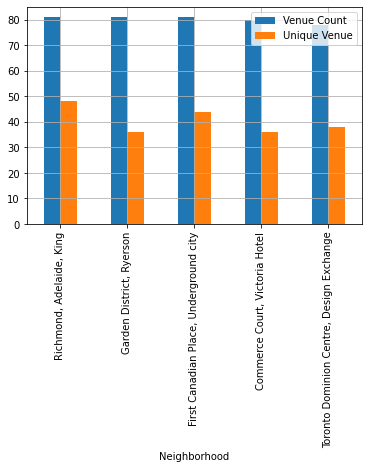

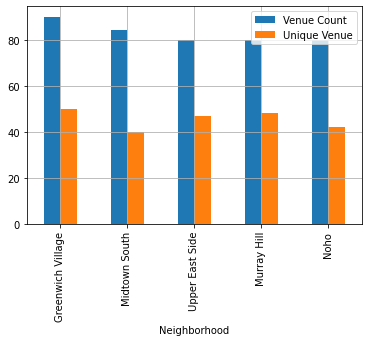

In [66]:
df_toronto.plot(x="Neighborhood", y=["Venue Count", "Unique Venue"], kind="bar", grid=True)
df_manhattan.plot(x="Neighborhood", y=["Venue Count", "Unique Venue"], kind="bar", grid=True)


## Results and Discussion <a name="results"></a>

After removing venues that aren't typically interesting to teenagers, we have determined the top 5 neighborhoods for both cities depending on the number of venue avaliable in the area. This decision was made because if an area has more venues, there will be more choices for the visitor and more likely for the visitor to find something that they will enjoy.


We have also determined the variaties of venues (AKA the unique types of venue) in each neighborhood, as this number could also factor into how much the person travelling will enjoy their visit to the area.


At last, we compared those data of 2 cities in the form of bar chart. Since the city of Manhattan is superior in both the number of venues and the types of venues in their top 5 neighborhoods. Therefore, it is reasonable to make the conclusion that Manhattan is a more fitting place to visit based on the information of venues given by the Foursquare API. Of course, this project only take consideration of one factor in this result, while there are many other factors that could potentially affect my decision. With enough time in the future, I'll take more factor into consideration while prefecting my results.

## Conclusion <a name="conclusion"></a>

In conclusion, in terms of how a teenager could enjoy the venues in the area, Manhattan is a more fitting spot to visit than Toronto.

Some more factors to take into considerations in the future:
* distance between neighborhoods (or venues)
* the avaliability in the transportation system
* the avaliability of hotels in the area